<a href="https://colab.research.google.com/github/sravangvm/Covid-Classification-Using-X-Rays/blob/main/Covid_Xray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!wget https://github.com/ieee8023/covid-chestxray-dataset/blob/master/metadata.csv

In [ ]:
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

In [ ]:
!unzip /content/coronahack-chest-xraydataset.zip

Archive:  /content/coronahack-chest-xraydataset.zip
replace Chest_xray_Corona_Metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/master.zip

Archive:  /content/master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
replace covid-chestxray-dataset-master/.github/FUNDING.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import os
import numpy as np

datapath1='covid-chestxray-dataset-master'
dataset_path='/content/gdrive/MyDrive/dataset'
  
categories=os.listdir(dataset_path)
print(categories)

dataset=pd.read_csv(os.path.join(datapath1,'metadata.csv'))
findings=dataset['finding']
image_names=dataset['filename']

['Covid19 Negative', 'Covid19 Positive']


In [ ]:
positives_index=np.concatenate((np.where(findings=='COVID-19')[0],np.where(findings=='SARS')[0]))
positive_image_names=image_names[positives_index]
import cv2

for positive_image_name in positive_image_names:
    image=cv2.imread(os.path.join(datapath1,'images',positive_image_name))
    try:
        cv2.imwrite(os.path.join(dataset_path,categories[1],positive_image_name),image)
    except Exception as e:
        print(e)

In [ ]:
dataset=pd.read_csv("/content/Chest_xray_Corona_Metadata.csv")
findings=dataset['Label']
image_names=dataset['X_ray_image_name']

In [ ]:
negative_index=np.where(findings=='Normal')[0]
negative_image_names=image_names[negative_index]
for negative_image_name in negative_image_names:
    image=cv2.imread(os.path.join('images',negative_image_name))
    try:
        cv2.imwrite(os.path.join(dataset_path,categories[0],negative_image_name),image)
    except Exception as e:
        print(e)
      

In [ ]:
import cv2,os

data_path='/content/gdrive/MyDrive/dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Covid19 Negative': 0, 'Covid19 Positive': 1}
['Covid19 Negative', 'Covid19 Positive']
[0, 1]


In [ ]:
img_size=100
data=[]
target=[]
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [ ]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)
np.save('data',data)
np.save('target',new_target)

In [ ]:
data=np.load('data.npy')
target=np.load('target.npy')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D,Dropout

model=Sequential()

model.add(Conv2D(64,(3,3),input_shape=(100,100,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [ ]:
from keras.callbacks import *
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto',save_weights_only=True)
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/20
18/18 [==============================] - 1s 40ms/step - loss: 0.5579 - accuracy: 0.7750 - val_loss: 0.6261 - val_accuracy: 0.6613
Epoch 2/20
18/18 [==============================] - 1s 29ms/step - loss: 0.4866 - accuracy: 0.8076 - val_loss: 0.6022 - val_accuracy: 0.6613
Epoch 3/20
18/18 [==============================] - 0s 27ms/step - loss: 0.4213 - accuracy: 0.8131 - val_loss: 0.5093 - val_accuracy: 0.7903
Epoch 4/20
18/18 [==============================] - 0s 19ms/step - loss: 0.3741 - accuracy: 0.8548 - val_loss: 0.6260 - val_accuracy: 0.8226
Epoch 5/20
18/18 [==============================] - 1s 28ms/step - loss: 0.3699 - accuracy: 0.8693 - val_loss: 0.4547 - val_accuracy: 0.8387
Epoch 6/20
18/18 [==============================] - 0s 20ms/step - loss: 0.3455 - accuracy: 0.8820 - val_loss: 0.5936 - val_accuracy: 0.8387
Epoch 7/20
18/18 [==============================] - 0s 19ms/step - loss: 0.2760 - accuracy: 0.9038 - val_loss: 0.5134 - val_accuracy: 0.8387
Epoch 8/20
18

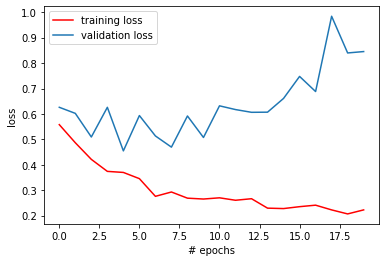

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()